## LST - Tair #2

In [1]:
import calendar
from datetime import date
import datetime
from math import radians, cos, sin, asin, sqrt
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from progressbar import ProgressBar
import pykrige
import rasterio as rio
from scipy.optimize import curve_fit
from skgstat.models import spherical, exponential, gaussian
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings("ignore")

Load Data

In [3]:
#latlon pandas dataframe

latlon = pd.read_csv(
    'Data/lat.csv', 
    index_col = 0)

latlon = latlon.drop('Inhambane')
latlon = latlon.drop('Quelimane')

In [4]:
# Load dataframes

TNA = pd.read_csv('Data/dataframes/TNA.csv', index_col = 0, parse_dates = ['Date'])
TDA = pd.read_csv('Data/dataframes/TDA.csv', index_col = 0, parse_dates = ['Date'])

Tmin = pd.read_csv('Data/dataframes/Tmin.csv', index_col = 0, parse_dates = ['Date'])
Tmax = pd.read_csv('Data/dataframes/Tmax.csv', index_col = 0, parse_dates = ['Date'])

**Functions**

In [5]:
def spatial_serie(time_step, T, LST):
    
    df = pd.DataFrame(np.nan, index=T.columns.values, columns = ['T', 'LST'])
    df['T'] = T.loc[time_step].values
    df['LST'] = LST.loc[time_step].values

    return df

def fromdekad(x):

    # seeking for date pattern in the filename
    dek = re.search(r'\d{4}\d{2}D\d{1}', x).group()

    # getting year, month and dekad
    year = int(dek[0:4])
    month = int(dek[4:6])
    d = dek[6:8]
    
    if d=="D1":
        greg_date = date(year,month,10)
    elif d=="D2":
        greg_date = date(year,month,20)
    else:
        greg_date = date(year,month,28)
        
    return greg_date

LOOCV function

In [6]:
def LOOCV(df):
    
    n_station = len(df)
    X = df['LST'].values.reshape(-1,1)
    Y = df['T'].values.reshape(-1,1)

    #Residuals
    lm = LinearRegression()
    model = lm.fit(X, Y)
    pred = model.predict(X)
    res = pred - Y

    #Calculating RMSE
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    crossvalidation = KFold(n_splits=n_station, random_state=None, shuffle=False)
    scores = cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=crossvalidation, n_jobs=1)
    RMSE = np.sqrt(np.mean(np.abs(scores)))
    
    return(res, RMSE, model)

Distance

In [7]:
def distance(s1, s2, latlon):
    
    lat1 = latlon.loc[s1].Lat; lon1 = latlon.loc[s1].Lon
    lat2 = latlon.loc[s2].Lat; lon2 = latlon.loc[s2].Lon
    
    #Convert degree to radian
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2)
    
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. 
    r = 6371
       
    # calculate the result 
    dist = (c * r)
    
    return dist

Calulate variogram

In [8]:
def calculate_variance(M, stations, max_dist):
    
    variance = np.zeros(len(M.index.values))
    
    for n,d in enumerate(M.index.values):  #looping over time
        
        count = 0
        sumsqdiff = 0
        
        for s1 in stations:  #looping over stations
            for s2 in stations:
                
                dist = distance(s1, s2, latlon)
                
                if dist<max_dist:
                    diff = M.loc[d][s1] - M.loc[d][s2]
                    sqdiff = diff*diff

                    if np.isnan(sqdiff):
                        sqdiff = 0
                        count -= 1

                    sumsqdiff += sqdiff
                    count += 1
                
        if (count>0):
            variance[n] = (sumsqdiff/(count*2))
    
    return variance

In [9]:
def month_vario(m, res_df, latlon, bin_size):
    
    stations = latlon.index.values
    number = len(stations)*(len(stations)-1) / 2
    
    max_dist = 1000
    n_bins = int(max_dist/bin_size); 

    if (n_bins > number):
        print("More bins than data points! Use a wider bin size")
        return
    
    M = res_df[res_df.index.month == m]
    dates_M = M.index.values
           
    sumsqdiff = np.zeros(n_bins)
    count = np.zeros(n_bins)
    sumdist = 0
    numdist = 0
    
    variance = calculate_variance(M, stations, max_dist)
    
    #Building Variogram
    for s1 in stations:
        for s2 in stations:

            dist = distance(s1, s2, latlon)
            
            if dist<max_dist:
            
                bin_no = int(dist/bin_size)

                for n,d in enumerate(dates_M):

                    diff = M.loc[d][s1] - M.loc[d][s2]
                    sqdiff = diff*diff

                    #normalize
                    sqdiff = sqdiff/variance[n]

                    if np.isnan(sqdiff):
                        sqdiff = 0
                        count[bin_no] -= 1
                        sumdist -= dist
                        numdist -= 1

                    sumsqdiff[bin_no] += sqdiff
                    count[bin_no] += 1
                    sumdist += dist
                    numdist += 1
    
    count[count == 0] = np.nan
    
    return (sumsqdiff/(2*count), sumdist/numdist, count)

Fit Variogram

In [10]:
def f1(h, a, b, n):
    return spherical(h, a, b, n)

def f2(h, a, b, n):
    return exponential(h, a, b, n)

def f3(h, a, b, n):
    return gaussian(h, a, b, n)

def fit_vario(vario, fit_type, mean_dist, count):
    
    y = np.array([round(x,7) for x in vario])
    x = np.array(list(range(0,len(y))))
    
    #getting rid of NaN for fitting
    valid = ~(np.isnan(y))
    y = y[valid]
    x = x[valid]
    count = count[valid]
    
    mean_vario = np.mean(y)
    
    #Fitting the variogram. 
    #To optimize the fitting we set the as initial values the mean value of semi-variances for the sill, the mean separating distance as range and 0 for the nugget
    #We also add a sigma value to give more importance to the first points of the variogram
    
    #X = np.asarray([(_ + 1) for _ in list(range(len(y)))])
    #s = np.sqrt(X)
    s = np.array([1/x for x in count])
    
    if (fit_type == 'sph'):
        cof, cov = curve_fit(f1, x, y, p0 = [mean_vario, mean_dist, 0], sigma = s)
    elif (fit_type == 'exp'):
        cof, cov = curve_fit(f2, x, y, p0 = [mean_vario, mean_dist, 0], sigma = s)
    elif (fit_type == 'gau'):
        cof, cov = curve_fit(f3, x, y, p0 = [mean_vario, mean_dist, 0], sigma = s)
    else:
        print('Wrong fit_type ! Must be sph, exp or gau')
        return 

    
    return cof

Plot all months

In [11]:
def plot_all_vario(latlon, res_df, bin_size):
   
    fig, axs = plt.subplots(4,3, figsize=(20, 10))   
    
    #saving coefficients
    cof_sph, cof_exp, cof_gau = np.zeros((12,3)), np.zeros((12,3)), np.zeros((12,3))

    m = 1
    for i in range(4): #4
        for j in range(3): #3
            
            vario_calculated, mean_dist, count = month_vario(m, res_df, latlon, bin_size)
            xi = np.linspace(0, len(vario_calculated), 100)
                        
            cof = fit_vario(vario_calculated, 'sph', mean_dist, count)
            yi1 = list(map(lambda x: spherical(x, *cof), xi))
            cof_sph[m-1] = cof
            
            cof = fit_vario(vario_calculated, 'exp', mean_dist, count)
            yi2 = list(map(lambda x: exponential(x, *cof), xi))
            cof_exp[m-1] = cof
            
            cof = fit_vario(vario_calculated, 'gau', mean_dist, count)
            yi3 = list(map(lambda x: gaussian(x, *cof), xi))
            cof_gau[m-1] = cof
        
            axs[i,j].label_outer()
            axs[i,j].plot(xi, yi1)
            axs[i,j].plot(xi, yi2)
            axs[i,j].plot(xi, yi3)
            axs[i,j].plot(range(len(vario_calculated)), vario_calculated, '-o', color = 'grey')
            axs[i,j].set_title(calendar.month_name[m])
            axs[i,j].set_ylim([0,max(vario_calculated)+0.1])
            
            m = m+1
            
    fig.legend(['Spherical', 'Exponential', 'Gaussian'])
    
    return (cof_sph, cof_exp, cof_gau)

## RMSE analysis

We compute RMSE for every time step and stack the result in a DataFrame 

In [12]:
regression_df = pd.DataFrame(np.nan, index = TDA.index, columns = ['RMSE', 'slope', 'intercept'])
res_df = pd.DataFrame(np.nan, index = TDA.index, columns = TNA.columns)


pbar = ProgressBar()
for d in pbar(TDA.index.values):
    
    df = spatial_serie(d, Tmax, TDA)
    index_nan = [index for index, row in df.iterrows() if row.isnull().any()]    
    df = df.dropna()
    
    if (len(df)>2):
    
        (res, RMSE, mod) = LOOCV(df)
    
        regression_df.loc[d] = [RMSE, mod.coef_, mod.intercept_]
    
        i = 0
        for l in res_df.columns:
            if l not in index_nan:
                res_df.loc[d][l] = res[i]
                i = i+1  

100% |########################################################################|


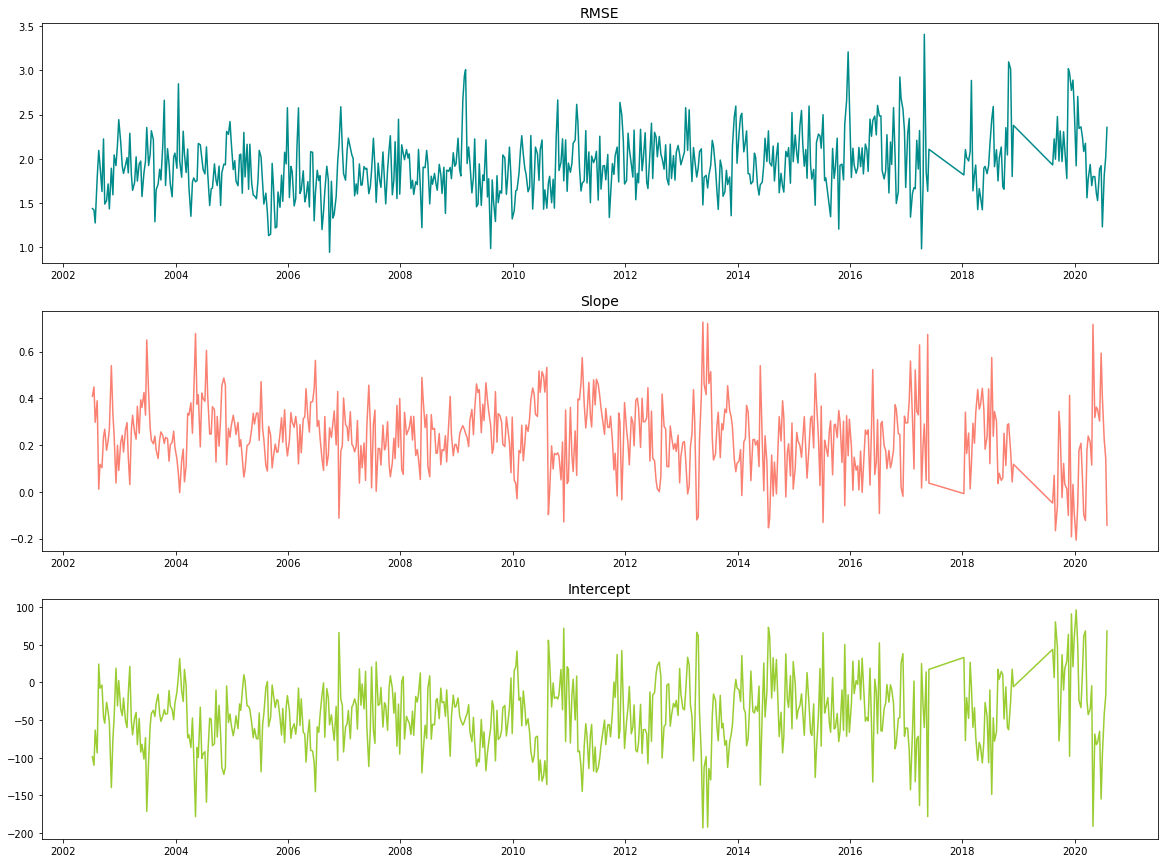

In [13]:
regression_df = regression_df.dropna()

#plotting the regression parameters
fig, axs = plt.subplots(3,1, figsize=(20, 15))

axs[0].plot(regression_df.RMSE, color='darkcyan')
axs[0].set_title('RMSE', fontsize = 14)
axs[1].plot(regression_df.slope, color='salmon')
axs[1].set_title('Slope', fontsize = 14)
axs[2].plot(regression_df.intercept, color='yellowgreen')
axs[2].set_title('Intercept', fontsize = 14);

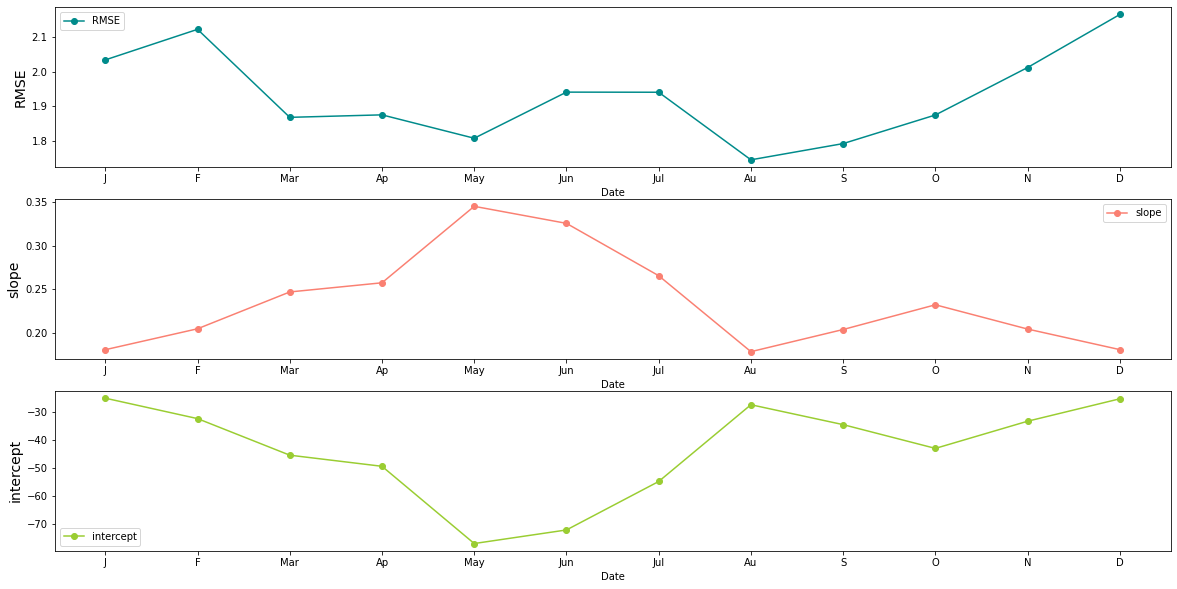

In [14]:
regression_df = regression_df.astype(float)
regression_month = regression_df.groupby([(regression_df.index.month)]).mean()

#plotting the regression parameters
fig, axs = plt.subplots(3,1, figsize=(20, 10))

regression_month.plot(y = ["RMSE"], color='darkcyan', style = '-o', xticks = regression_month.index, ax=axs[0])
axs[0].set_ylabel("RMSE",fontsize=14)
months = ['J', 'F', 'Mar', 'Ap', 'May', 'Jun', 'Jul', 'Au', 'S', 'O', 'N', 'D']
axs[0].set_xticklabels(months);

regression_month.plot(y = ["slope"], color='salmon', style = '-o', xticks = regression_month.index, ax=axs[1])
axs[1].set_ylabel("slope",fontsize=14)
axs[1].set_xticklabels(months);

regression_month.plot(y = ["intercept"], color='yellowgreen', style = '-o', xticks = regression_month.index, ax=axs[2])
axs[2].set_ylabel("intercept",fontsize=14)
axs[2].set_xticklabels(months);

Check of dates with high RMSE 

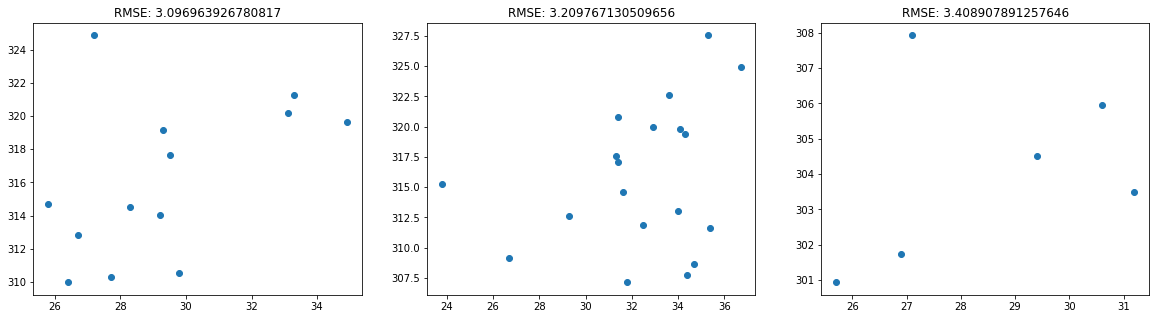

In [15]:
max_RMSE = regression_df.groupby('RMSE')['RMSE'].max().values[-3:]

fig, axs = plt.subplots(1,3, figsize=(20, 5))

for i,m in enumerate(max_RMSE):
    id_max = regression_df[regression_df['RMSE'] == m].index.values[0]
    a,b = TDA.loc[id_max].values, Tmax.loc[id_max].values
    axs[i].scatter(b,a)
    axs[i].set_title("RMSE: " + str(m))
    

### Building the Variogram

We build a calculated variogram using all data (from 2000 to 2020) of each month and computing $\gamma(h)$ for each $h$, with:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

With $h$ the distance between the points and $z(\bf{u}_\alpha)$ the value at point $\bf{u}_\alpha$.

This way we have a lot of data for each month. We then fit the empirical variogram with a curve (Spherical, Exponential or Gaussian). This fitted variogram will then be used further for kriging.

https://mmaelicke.github.io/scikit-gstat/technical/fitting.html

With **bin_size = 100**

--- 1057.3872547149658 seconds ---


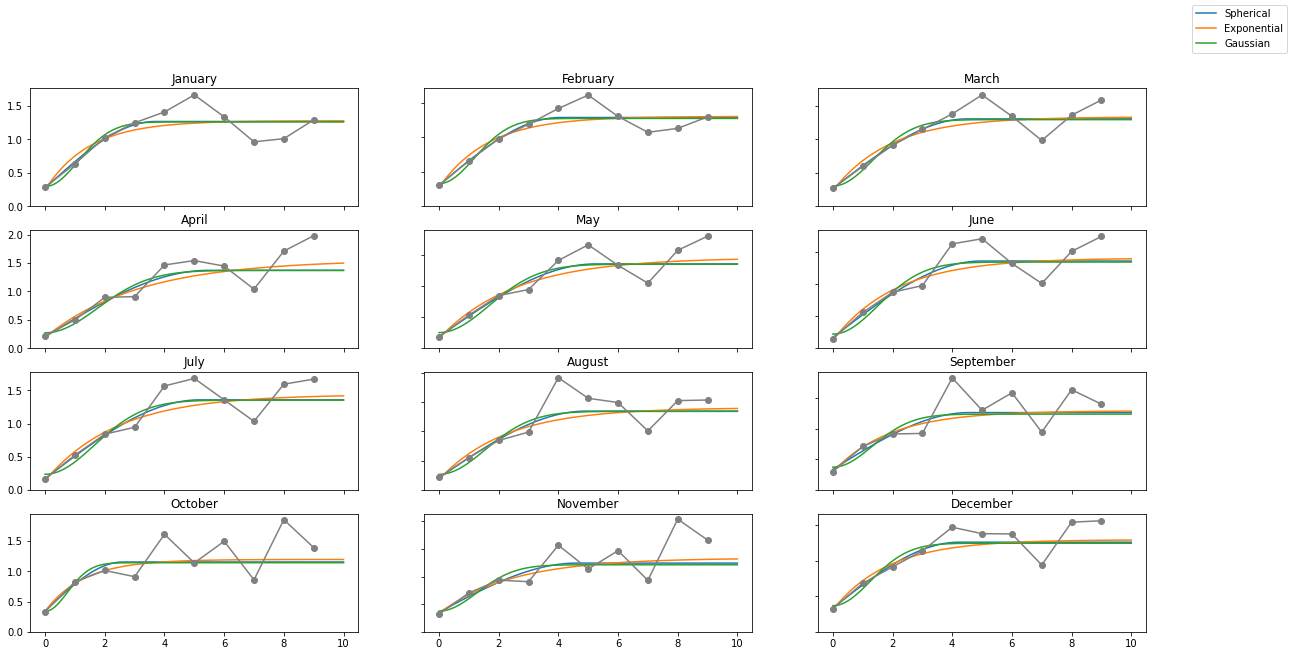

In [16]:
start_time = time.time()
(sph_100, exp_100, gau_100) = plot_all_vario(latlon, res_df, bin_size = 100)
print("--- %s seconds ---" % (time.time() - start_time))

With **bin_size = 50**

--- 895.3006160259247 seconds ---


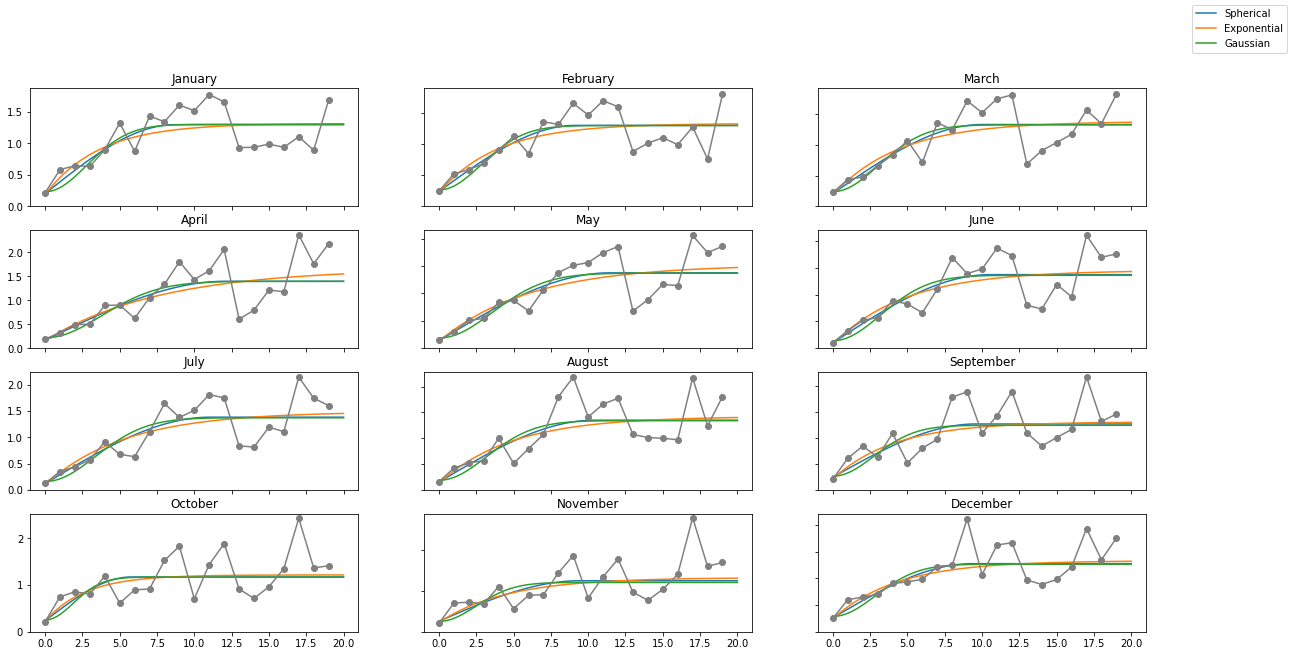

In [17]:
start_time = time.time()
(sph_50, exp_50, gau_50) = plot_all_vario(latlon, res_df, bin_size = 50)
print("--- %s seconds ---" % (time.time() - start_time))

With **bin_size = 20**

--- 891.0394129753113 seconds ---


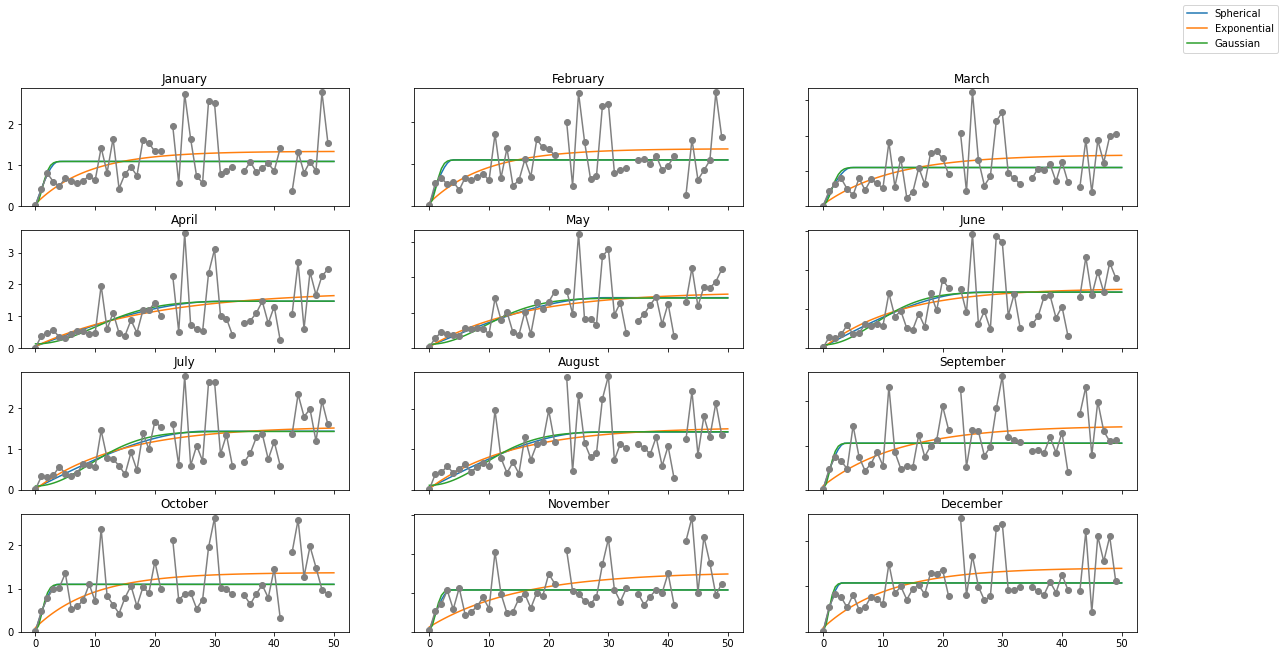

In [18]:
start_time = time.time()
(sph_20, exp_20, gau_20) = plot_all_vario(latlon, res_df, bin_size = 20)
print("--- %s seconds ---" % (time.time() - start_time))

By looking at the curves, we chose to keep the **Spherical fit** because it is generally the one representing better the variogram.  

**COMPARING MONTHS**

With **bin_size = 100**

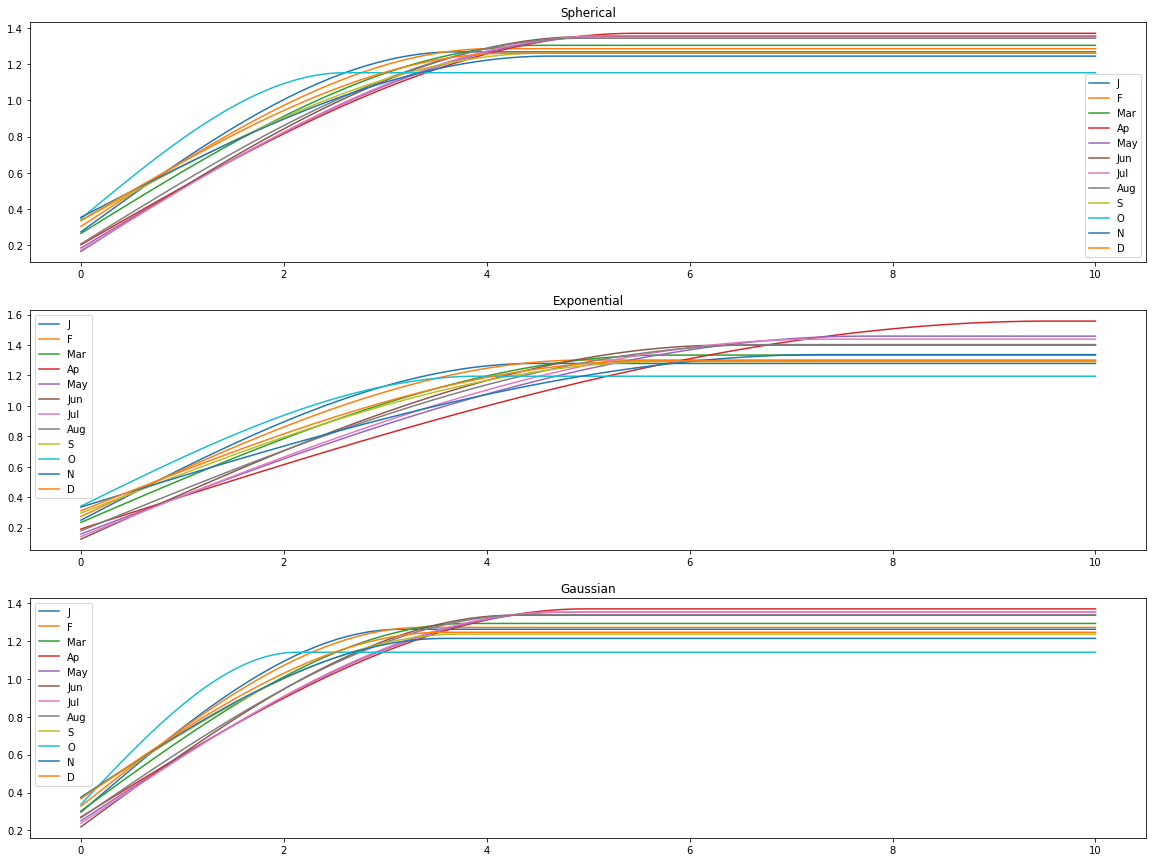

In [19]:
fig, axs = plt.subplots(3,1, figsize=(20, 15))

max_dist = 1000
bin_size = 100

cof_100 = [sph_100, exp_100, gau_100]
titles = ['Spherical', 'Exponential', 'Gaussian']
xi = np.linspace(0, max_dist/bin_size, 100)

for i,cof_list in enumerate(cof_100):
    for cof in cof_list:
        axs[i].plot(xi, list(map(lambda x: spherical(x, *cof), xi)))
        axs[i].legend(['J', 'F', 'Mar', 'Ap', 'May', 'Jun', 'Jul', 'Aug', 'S', 'O', 'N', 'D'])
    axs[i].set_title(titles[i])    

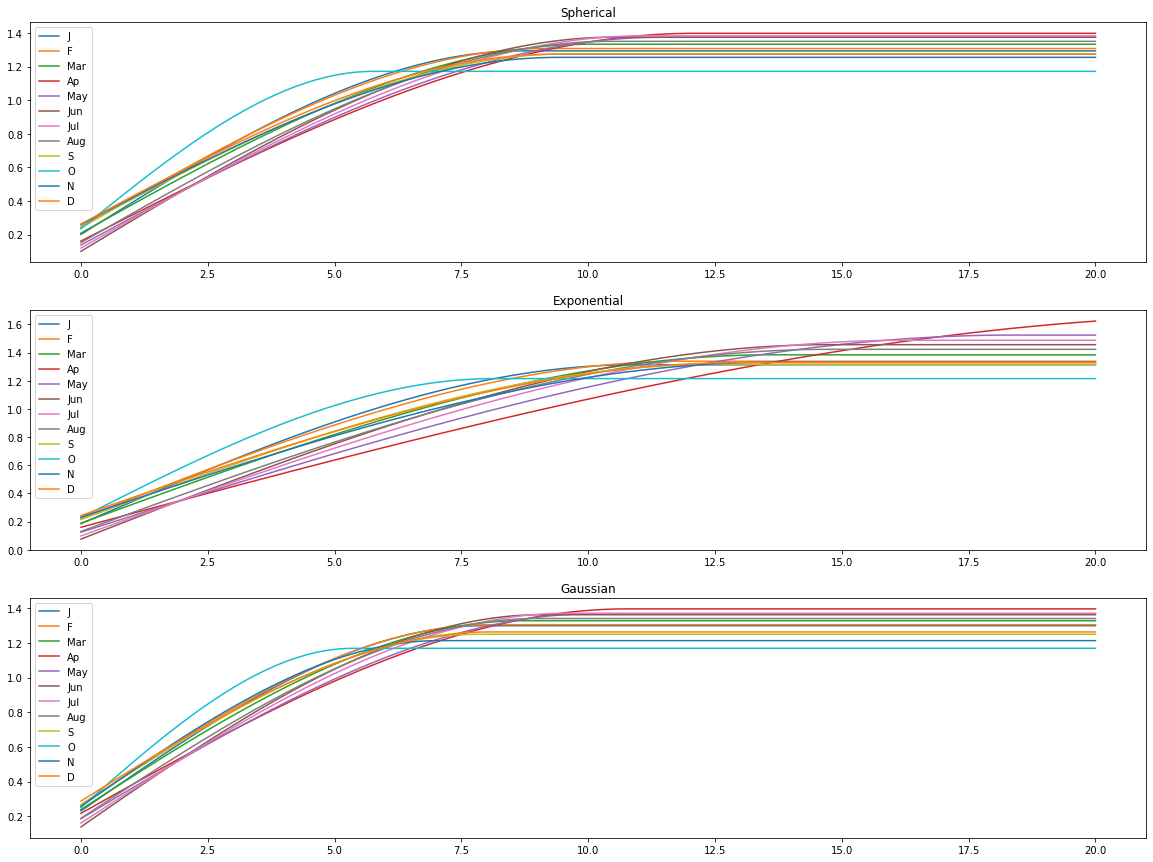

In [20]:
fig, axs = plt.subplots(3,1, figsize=(20, 15))

max_dist = 1000
bin_size = 50

cof_50 = [sph_50, exp_50, gau_50]
titles = ['Spherical', 'Exponential', 'Gaussian']
xi = np.linspace(0, max_dist/bin_size, 100)

for i,cof_list in enumerate(cof_50):
    for cof in cof_list:
        axs[i].plot(xi, list(map(lambda x: spherical(x, *cof), xi)))
        axs[i].legend(['J', 'F', 'Mar', 'Ap', 'May', 'Jun', 'Jul', 'Aug', 'S', 'O', 'N', 'D'])
    axs[i].set_title(titles[i])  

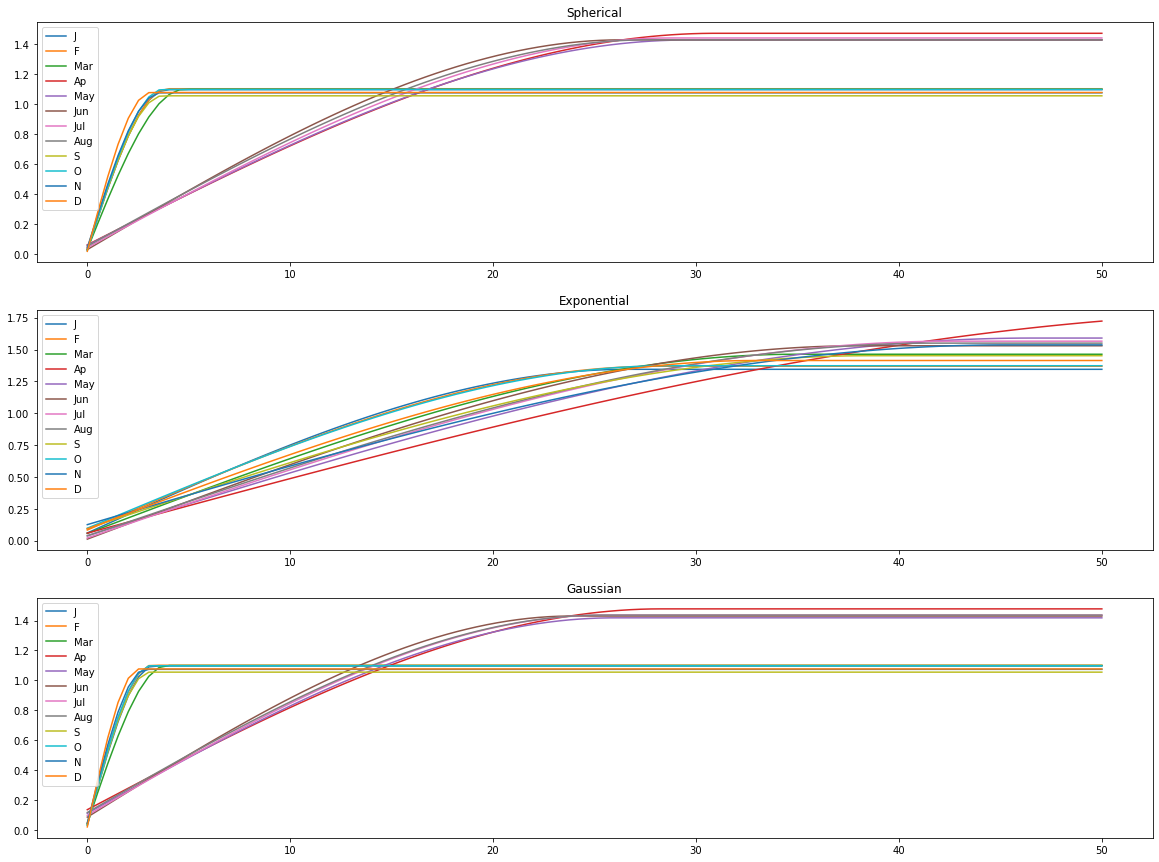

In [21]:
fig, axs = plt.subplots(3,1, figsize=(20, 15))

max_dist = 1000
bin_size = 20

cof_20 = [sph_20, exp_20, gau_20]
titles = ['Spherical', 'Exponential', 'Gaussian']
xi = np.linspace(0, max_dist/bin_size, 100)

for i,cof_list in enumerate(cof_20):
    for cof in cof_list:
        axs[i].plot(xi, list(map(lambda x: spherical(x, *cof), xi)))
        axs[i].legend(['J', 'F', 'Mar', 'Ap', 'May', 'Jun', 'Jul', 'Aug', 'S', 'O', 'N', 'D'])
    axs[i].set_title(titles[i])  

**Saving Variograms coefficients**

In [22]:
varios = {}

for i,cof in enumerate(sph_50):

    # [sill, range, nugget]
    varios[i+1] = [cof[1], cof[0], cof[2]]

## Using Variograms for kriging

We will use our fitted variogram in order to krig the residuals of the 2018-10-D1 raster.

In [23]:
time_step = '201810D1'

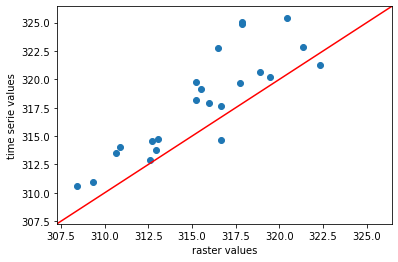

In [24]:
#Checking if raster and my data are the same

with rio.open('Data/rasters/moztda201810d1.tif') as src:
    
    aoi = src.read(1)
    vals = []
    for l in TDA.columns.values:
        coord = rio.transform.rowcol(src.transform, latlon.loc[l].Lon, latlon.loc[l].Lat)
        vals.append(aoi[coord[0],coord[1]]/50)   
        
df = pd.DataFrame(np.nan, index=TDA.columns.values, columns = ['raster', 'ts'])
df['raster'] = vals
df['ts'] = TDA.loc[date(2018,10,28)]

df = df[(df.T != 0).all()]
plt.scatter(df.raster, df.ts)
plt.xlabel('raster values')
plt.xlim(min([*df.raster, *df.ts])+1,max([*df.raster, *df.ts])+1)
plt.ylabel('time serie values')
plt.ylim(min([*df.raster, *df.ts])+1,max([*df.raster, *df.ts])+1)
plt.plot(np.linspace(0, 500), np.linspace(0, 500), color = 'r')

We already have quite a difference between the values of our time series and the raster. Reasons:
- Not the same smoothing (not over the same time)
- Not the same data used (daily or every 8 days)
- Not the same convertion to dekadal data

**Building regression model**

In [25]:
df = pd.DataFrame(np.nan, index=TDA.columns.values, columns = ['T', 'LST', 'Lat', 'Lon'])
df['LST'] = vals
df['T'] = Tmax.loc[fromdekad(time_step)].values
df['Lat'] = latlon['Lat'].values
df['Lon'] = latlon['Lon'].values
df[df['LST']==0] = np.nan
df = df.dropna()

(res, RMSE, model) = LOOCV(df)
aoi50 = aoi/50
pred = model.predict(aoi50.reshape(-1,1))
pred = pred.reshape(aoi.shape)

print('Model with coefficient ', model.coef_[0][0], ' and intercept ', model.intercept_[0])

Model with coefficient  0.22481032807732634  and intercept  -41.21074631219775


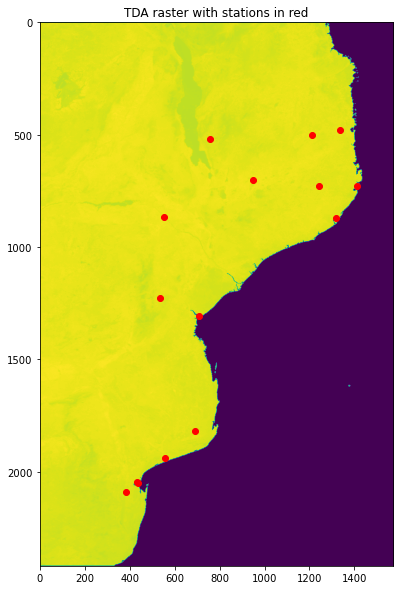

In [26]:
x = df.Lon.values
y = df.Lat.values
z = res

with rio.open('Data/rasters/moztda201810d1.tif') as src:
    plt.figure(figsize=(20,10))
    aoi = src.read(1) 
    im = plt.imshow(aoi);
    coord = []
    for i in range(len(x)):          
        coord.append(rio.transform.rowcol(src.transform, x[i], y[i]))
    lat = [i[0] for i in coord]
    lon = [i[1] for i in coord]
    plt.scatter(lon,lat, color = 'r')
    plt.title('TDA raster with stations in red')
    
    water_mask = [aoi!=0]

In [27]:
#Building the kriging model
krig = pykrige.ok.OrdinaryKriging(x, y, z, 
                                  variogram_model='spherical', variogram_parameters=varios[10], 
                                  coordinates_type = 'geographic')

In [28]:
da = xr.open_rasterio('Data/rasters/moztda201810d1.tif')
xp, yp = np.meshgrid(da['x'], da['y'])
xp = xp[0]
yp = np.array([yp[i][0] for i in range(len(yp))])

kriged_result = krig.execute(style = 'grid', xpoints = xp, ypoints = yp)

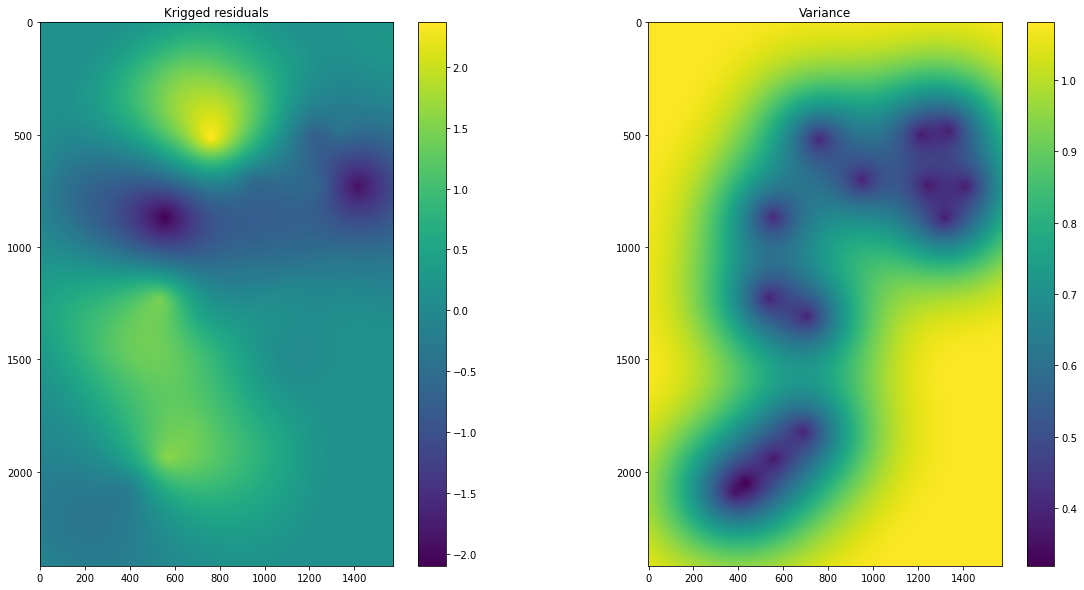

In [29]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))

im0 = axs[0].imshow(kriged_result[0].data)
fig.colorbar(im0, ax=axs[0])
axs[0].set_title('Krigged residuals')

im1 = axs[1].imshow(kriged_result[1].data)
fig.colorbar(im1, ax=axs[1])
axs[1].set_title('Variance');

**Overview of all plots**

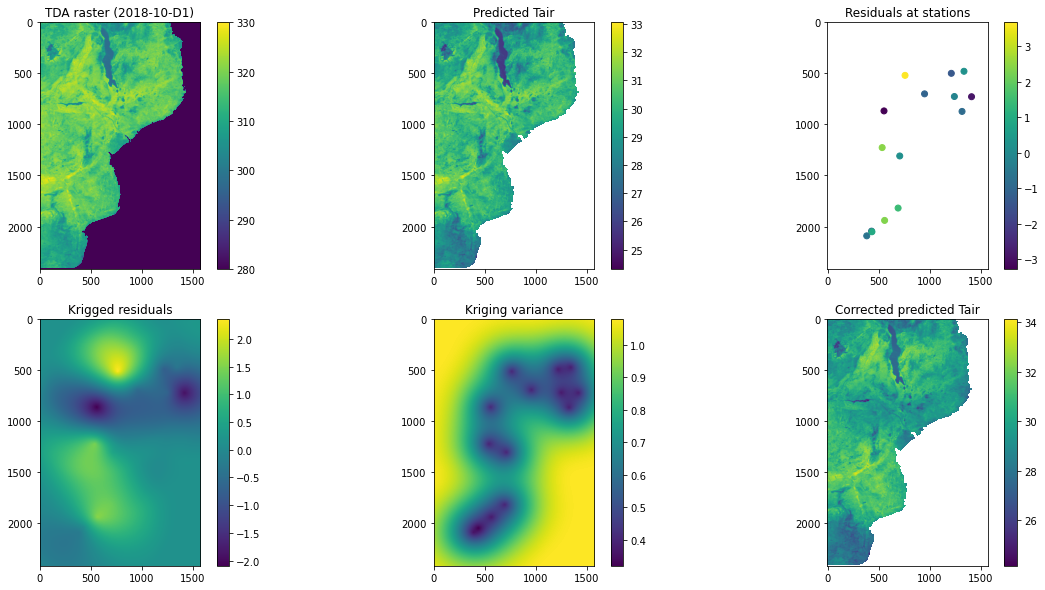

In [30]:
fig, axs = plt.subplots(2,3, figsize=(20, 10))

im = axs[0,0].imshow(aoi/50)
fig.colorbar(im, ax=axs[0,0])
im.set_clim(280,330)
axs[0,0].set_title('TDA raster (2018-10-D1)')

pred[~water_mask[0]] = np.nan
im = axs[0,1].imshow(pred)
fig.colorbar(im, ax=axs[0,1])
axs[0,1].set_title('Predicted Tair')

im = axs[0,2].imshow(aoi*np.nan)
im = axs[0,2].scatter(lon, lat, c = z)
fig.colorbar(im, ax=axs[0,2])
axs[0,2].set_title('Residuals at stations')

im = axs[1,0].imshow(kriged_result[0].data)
fig.colorbar(im, ax=axs[1,0])
axs[1,0].set_title('Krigged residuals')

im = axs[1,1].imshow(kriged_result[1].data)
fig.colorbar(im, ax=axs[1,1])
axs[1,1].set_title('Kriging variance')

corrected_Tair = np.add(pred, kriged_result[0].data)
corrected_Tair[~water_mask[0]] = np.nan
im = axs[1,2].imshow(corrected_Tair)
fig.colorbar(im, ax=axs[1,2])
axs[1,2].set_title('Corrected predicted Tair');